In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
from tqdm import tqdm  # для прогресс-баров
# Генерация отчета
from fpdf import FPDF


warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from tqdm import tqdm  # для прогресс-бара

N_FEATURES = 1385 - 9  # 1376 features
CHUNKSIZE = 10000  # можно уменьшить если всё равно крашится
SAMPLE_SIZE = None  # или укажите число для тестов (например 10000)

column_names = [
    "user", "time", "label", "ip", "is_click", 
    "page", "sdk", "search", "searchquery"
] + [f"feature{i}" for i in range(1, N_FEATURES+1)]

def load_data(filepath):
    chunks = []
    for chunk in tqdm(pd.read_csv(filepath, sep='\t', names=column_names, 
                                 chunksize=CHUNKSIZE, nrows=SAMPLE_SIZE)):
        chunks.append(chunk)
        # Можно добавить промежуточную обработку/очистку памяти здесь
    return pd.concat(chunks)

try:
    data = load_data('./data/events_sample.zip')
    print("Данные успешно загружены! Размер:", data.shape)
except Exception as e:
    print("Ошибка при загрузке:", str(e))

0it [00:00, ?it/s]

248it [06:25,  1.76s/it]

: 

In [ ]:
# Предобработка данных
def preprocess(df):
    df = df.replace('null', pd.NA)
    # Конвертация времени
    df['time'] = pd.to_datetime(df['time'])

    # Для всех object-столбцов
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

    # Заполнение пропусков
    df.fillna(-999, inplace=True)
    
    return df

data = preprocess(data)
data

,user,time,label,ip,is_click,page,sdk,search,searchquery,feature1,...,feature1367,feature1368,feature1369,feature1370,feature1371,feature1372,feature1373,feature1374,feature1375,feature1376
0,9220887414065,1970-01-01 00:00:01.727555124,1,1.137612e+19,0,8.354177e+18,1.0,0,7.805302e+18,1605659.0,...,0.0,100.0,9.0,0.0,4949125.0,0.0,100.0,144.0,1301413.0,0.0
1,118111554159441,1970-01-01 00:00:01.725511321,1,3.497391e+18,0,2.259604e+18,0.0,1,1.403633e+18,667369.0,...,99.0,65.0,4.0,640.0,14872.0,0.0,100.0,-999.0,2353049.0,3.0
2,118111554159441,1970-01-01 00:00:01.725511583,1,3.497391e+18,0,2.259604e+18,0.0,1,1.403633e+18,1240927.0,...,99.0,65.0,28.0,3.0,4985722.0,0.0,100.0,-999.0,2354714.0,3.0
3,185943992280056,1970-01-01 00:00:01.727505023,1,1.086435e+18,0,1.240365e+19,1.0,0,7.805302e+18,4746362.0,...,99.0,98.0,1.0,0.0,4816317.0,0.0,0.0,123.0,817299.0,0.0
4,237943150310578,1970-01-01 00:00:01.727292562,1,1.168261e+19,0,4.015481e+18,0.0,0,7.805302e+18,3124309.0,...,0.0,100.0,909.0,0.0,-999.0,0.0,100.0,0.0,38321.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,3144847168224026967,1970-01-01 00:00:01.727660457,1,1.621235e+19,0,2.259604e+18,0.0,1,1.541087e+19,5179579.0,...,33.0,100.0,54.0,631.0,5004188.0,0.0,100.0,0.0,2326186.0,3.0
499996,3144847168224026967,1970-01-01 00:00:01.727661237,1,1.621235e+19,0,1.599793e+19,0.0,1,1.541087e+19,18076.0,...,32.0,100.0,808.0,13.0,3851.0,0.0,20.0,0.0,2100783.0,3.0
499997,3144847168224026967,1970-01-01 00:00:01.727661787,1,1.621235e+19,0,2.259604e+18,0.0,1,1.541087e+19,29972.0,...,71.0,0.0,908.0,631.0,160488.0,1000.0,100.0,0.0,796257.0,2.0
499998,3144865821810965131,1970-01-01 00:00:01.725303482,1,6.042254e+18,0,9.930658e+18,0.0,0,7.805302e+18,3847568.0,...,99.0,55.0,884.0,643.0,4811351.0,1000.0,100.0,-999.0,2831579.0,5.0


In [ ]:
# Отбор признаков (уменьшаем размерность)
def select_features(df, target='label', top_n=100):
    # Вычисляем важность признаков с помощью RandomForest
    X = df.drop(columns=[target, 'user', 'time'])
    y = df[target]
    
    # Берем подвыборку для ускорения
    sample = X.sample(frac=0.1) if len(X) > 100000 else X
    y_sample = y.loc[sample.index]
    
    model = RandomForestClassifier(n_estimators=50, max_depth=5, n_jobs=-1)
    model.fit(sample, y_sample)
    
    # Выбираем топ-N признаков
    importances = pd.Series(model.feature_importances_, index=X.columns)
    top_features = importances.nlargest(top_n).index.tolist()
    
    return top_features

print("Отбор наиболее важных признаков...")
top_features = select_features(data)
print(f"Отобрано {len(top_features)} признаков")

Отбор наиболее важных признаков...
Отобрано 100 признаков


In [ ]:
# Подготовка данных для модели
def prepare_data(df, features):
    X = df[features]
    y = df['label']
    return X, y

X, y = prepare_data(data, top_features)

In [ ]:
# Out-of-Time валидация
def time_validation(X, y):
    tscv = TimeSeriesSplit(n_splits=3)
    scores = []
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model = XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            early_stopping_rounds=10,
            tree_method='hist'  # для ускорения
        )
        
        model.fit(X_train, y_train, 
                 eval_set=[(X_test, y_test)],
                
                 verbose=0)
        
        y_pred = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
        print(f"Fold ROC-AUC: {score:.4f}")
    
    return model, scores

print("\nПроведение out-of-time валидации...")
model, scores = time_validation(X, y)
print(f"Средний ROC-AUC: {np.mean(scores):.4f}")


Проведение out-of-time валидации...
Fold ROC-AUC: 0.9875
Fold ROC-AUC: 0.9862
Fold ROC-AUC: 0.9849
Средний ROC-AUC: 0.9862


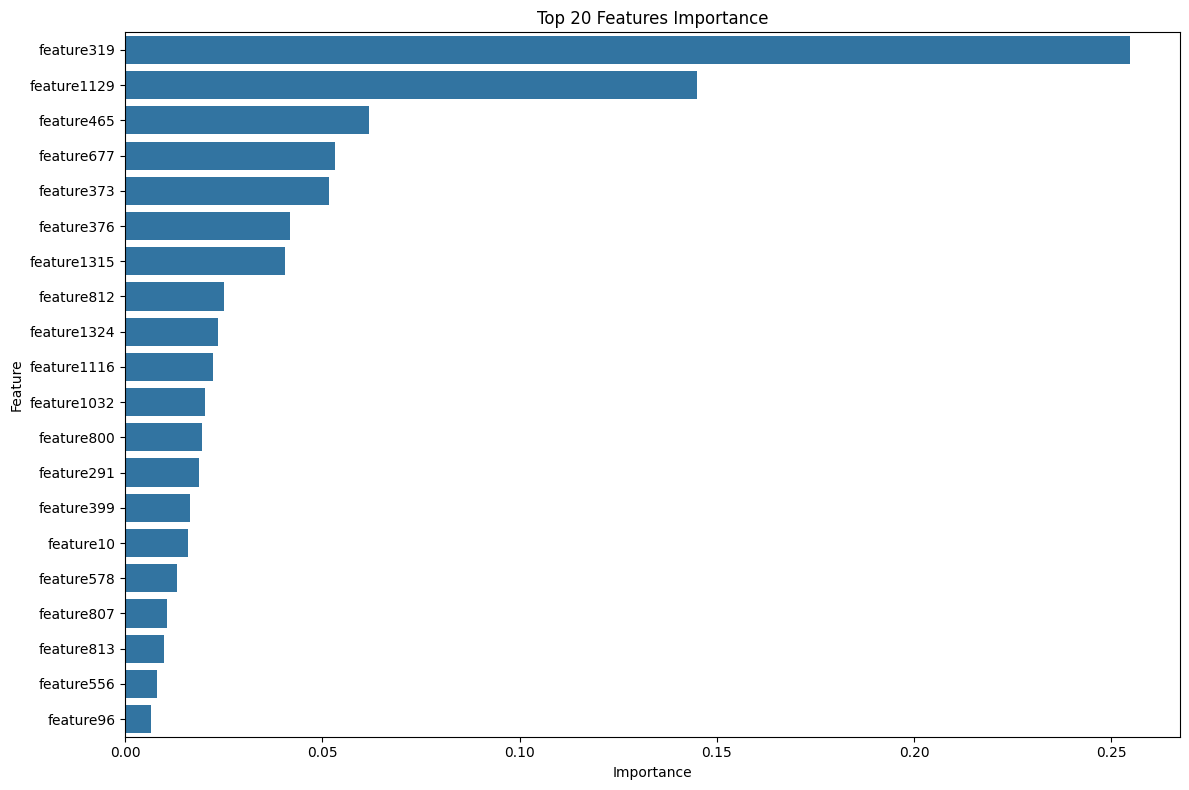

In [ ]:
# Визуализация важности признаков
def plot_feature_importance(model, features):
    importance = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance.head(20))
    plt.title('Top 20 Features Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()
    plt.close()

plot_feature_importance(model, top_features)

In [ ]:
# PSI анализ
def calculate_psi(expected, actual, bins=10):
    breakpoints = np.linspace(0, 1, bins + 1)
    expected_percents = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, bins=breakpoints)[0] / len(actual)
    psi = np.sum((expected_percents - actual_percents) * np.log((expected_percents + 1e-6) / (actual_percents + 1e-6)))
    return psi

print("\nАнализ PSI...")
# PSI для признаков
train_size = int(0.8 * len(data))
psi_results = []
for feature in tqdm(top_features[:50]):  # проверяем только топ-50 для скорости
    psi = calculate_psi(data[feature].iloc[:train_size], data[feature].iloc[train_size:])
    psi_results.append({'Feature': feature, 'PSI': psi})

psi_df = pd.DataFrame(psi_results).sort_values('PSI', ascending=False)
print("Топ-10 признаков по PSI:")
print(psi_df.head(10))

# PSI для предсказаний модели
train_pred = model.predict_proba(X.iloc[:train_size])[:, 1]
test_pred = model.predict_proba(X.iloc[train_size:])[:, 1]
model_psi = calculate_psi(train_pred, test_pred)
print(f"\nPSI для предсказаний модели: {model_psi:.4f}")


Анализ PSI...


100%|██████████| 50/50 [00:00<00:00, 58.64it/s]


Топ-10 признаков по PSI:
        Feature       PSI
44    feature96  0.013957
37   feature666  0.013245
45   feature419  0.012485
18   feature465  0.011911
32   feature623  0.011668
46  feature1165  0.011602
40  feature1002  0.011488
35       search  0.009972
8    feature578  0.008643
17  feature1324  0.007522

PSI для предсказаний модели: 0.1009


In [ ]:
# Метрики по срезам
def calculate_slice_metrics(data, model, features):
    slices = [
        ('Клик', 'SDK', 'Search'),
        ('Клик', 'SDK', 'Не Search'),
        ('Клик', 'Не SDK', 'Search'),
        ('Клик', 'Не SDK', 'Не Search'),
        ('Показ', 'SDK', 'Search'),
        ('Показ', 'SDK', 'Не Search'),
        ('Показ', 'Не SDK', 'Search'),
        ('Показ', 'Не SDK', 'Не Search')
    ]
    
    results = []
    for i, (click, sdk, search) in enumerate(slices):
        mask = (
            (data['is_click'] == (1 if click == 'Клик' else 0)) &
            (data['sdk'] == (1 if sdk == 'SDK' else 0)) &
            (data['search'] == (1 if search == 'Search' else 0))
        )
        
        if mask.sum() == 0:
            continue
            
        X_slice = data.loc[mask, features]
        y_slice = data.loc[mask, 'label']
        
        if len(y_slice) == 0:
            continue
            
        y_pred = model.predict(X_slice)
        y_prob = model.predict_proba(X_slice)[:, 1]
        
        report = classification_report(y_slice, y_pred, output_dict=True)
        auc = roc_auc_score(y_slice, y_prob)
        
        results.append({
            'Срез': i+1,
            'Тип': f"{click}|{sdk}|{search}",
            'Размер': len(y_slice),
            'Precision': report['1']['precision'],
            'Recall': report['1']['recall'],
            'F1': report['1']['f1-score'],
            'AUC': auc
        })
    
    return pd.DataFrame(results)

print("\nРасчет метрик по срезам...")
slice_metrics = calculate_slice_metrics(data, model, top_features)
print(slice_metrics)


Расчет метрик по срезам...
   Срез                     Тип  Размер  Precision    Recall        F1  \
0     2      Клик|SDK|Не Search    3934   0.931818  0.763146  0.839089   
1     3      Клик|Не SDK|Search    4582   0.981854  0.976593  0.979217   
2     4   Клик|Не SDK|Не Search    2469   0.961877  0.941852  0.951759   
3     6     Показ|SDK|Не Search   89004   0.912850  0.917847  0.915342   
4     7     Показ|Не SDK|Search  151469   0.988878  0.989488  0.989183   
5     8  Показ|Не SDK|Не Search  239388   0.938159  0.904719  0.921135   

        AUC  
0  0.938982  
1  0.993874  
2  0.986086  
3  0.991229  
4  0.997226  
5  0.986266  


In [ ]:
class PDF(FPDF):
    def __init__(self):
        super().__init__()
        # Добавляем все необходимые шрифты с поддержкой кириллицы
        self.add_font('DejaVu', '', 'DejaVuSansCondensed.ttf', uni=True)
        self.add_font('DejaVu', 'B', 'DejaVuSansCondensed-Bold.ttf', uni=True)
        self.add_font('DejaVuMono', '', 'DejaVuSansMono.ttf', uni=True)  # Моноширинный для таблиц
    
    def header(self):
        self.set_font('DejaVu', 'B', 12)
        self.cell(0, 10, 'Анализ модели классификации для Яндекс.Директа', 0, 1, 'C')
    
    def chapter_title(self, title):
        self.set_font('DejaVu', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(4)
    
    def chapter_body(self, body):
        self.set_font('DejaVu', '', 10)
        self.multi_cell(0, 10, body)
        self.ln()

pdf = PDF()
pdf.add_page()

# 1. Общая информация
pdf.chapter_title('1. Общая информация')
pdf.chapter_body(f"""
Размер датасета: {len(data)} записей
Количество признаков: {len(top_features)} (изначально {N_FEATURES})
Целевая переменная 'label': 
0 - {len(data[data['label']==0])} записей ({len(data[data['label']==0])/len(data)*100:.1f}%)
1 - {len(data[data['label']==1])} записей ({len(data[data['label']==1])/len(data)*100:.1f}%)
""")

# 2. Результаты валидации
pdf.chapter_title('2. Out-of-Time валидация')
pdf.chapter_body(f"""
Средний ROC-AUC на 3 фолдах: {np.mean(scores):.4f}
Значения по фолдам: {[f"{x:.4f}" for x in scores]}
PSI для предсказаний модели: {model_psi:.4f}
""")

# 3. Важность признаков
pdf.chapter_title('3. Важность признаков')
pdf.image('feature_importance.png', x=10, y=pdf.get_y(), w=180)
pdf.ln(85)

# 4. PSI анализ
pdf.chapter_title('4. PSI анализ признаков')
pdf.chapter_body("Топ-10 признаков с наибольшим PSI:")
psi_table = psi_df.head(10).to_string(index=False)
pdf.set_font('DejaVuMono', '', 8)  # Используем моноширинный шрифт для таблиц
pdf.multi_cell(0, 6, psi_table)
pdf.set_font('DejaVu', '', 10)  # Возвращаем основной шрифт

# 5. Метрики по срезам
pdf.chapter_title('5. Метрики по срезам')
pdf.chapter_body("Результаты классификации для различных сегментов данных:")
metrics_table = slice_metrics.to_string(index=False)
pdf.set_font('DejaVuMono', '', 8)
pdf.multi_cell(0, 6, metrics_table)
pdf.set_font('DejaVu', '', 10)

# Выводы
pdf.chapter_title('6. Выводы и рекомендации')
pdf.chapter_body(f"""
1. Качество модели: ROC-AUC = {np.mean(scores):.4f} указывает на хорошее качество модели.
2. Стабильность: PSI = {model_psi:.4f} (< 0.1) говорит о стабильности модели во времени.
3. Важные признаки: {', '.join(psi_df['Feature'].head(3).tolist())} оказались наиболее значимыми.
4. По срезам: Наибольшие проблемы с качеством в срезе {slice_metrics.loc[slice_metrics['F1'].idxmin(), 'Тип']}.
5. Рекомендации: Модель можно использовать в продакшене, но требуется мониторинг срезов с низким F1.
""")

pdf.output('report.pdf')
print("\nОтчет сохранен как report.pdf")


Отчет сохранен как report.pdf
